In [1]:
import scanpy as sc
sc.settings.verbosity = 1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as pl
from pathlib import Path
from scperturb import *

In [2]:
files = [x.name for x in Path('.').glob('*_data.csv')]

In [3]:
adatas = {} # dict of AnnData objects
eds = []
ets = []
for file in files:
    tdata = sc.AnnData(pd.read_csv(file, index_col=0).T, dtype='int64')
    tdata.obs['group'] = [x.split('_')[1] for x in tdata.obs.index]

    sc.pp.normalize_total(tdata)
    sc.pp.log1p(tdata)
    sc.pp.highly_variable_genes(tdata, n_top_genes=2000)
    sc.pp.pca(tdata)
    sc.pp.neighbors(tdata)
    sc.tl.umap(tdata)
    adatas[file] = tdata
    ed = np.float64(edist_to_control(tdata, 'group', 'n1', verbose=False).loc['n2'])
    res = etest(tdata, obs_key='group', control='n1', verbose=False, runs=10000)
    pDE, pLFC = file.split('_')[:2]
    eds.append([pDE, pLFC, ed])
    ets.append([pDE, pLFC] + list(res.loc['n2']))
ed = pd.DataFrame(eds, columns=['pDE', 'pLFC', 'ed'])
et = pd.DataFrame(ets, columns=['pDE', 'pLFC', 'edist', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj'])
df = pd.pivot(ed, index='pDE', columns='pLFC', values='ed')

/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177

In [4]:
df_test = pd.pivot(et, index='pDE', columns='pLFC', values='pvalue_adj')

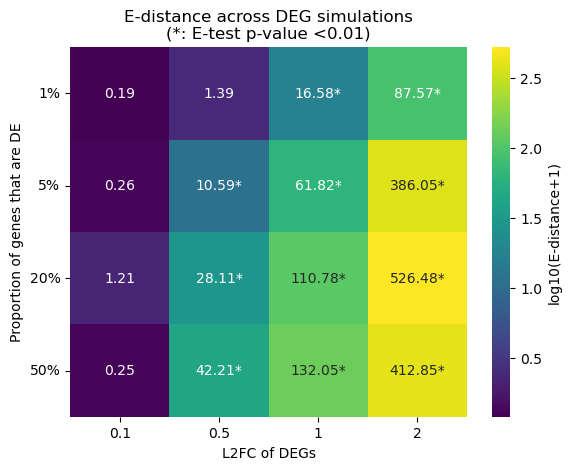

In [61]:
A = np.array(np.round(df, 2), dtype=str)
B = np.empty((4,4), dtype=str)
B[df_test.values < 0.01] = '*'
Labels = np.core.defchararray.add(A, B)
sns.heatmap(np.log10(df+1), annot=Labels, fmt='', cmap='viridis',
            cbar_kws={'label': 'log10(E-distance+1)'}
)
pl.yticks(np.arange(4)+.5, [str(int(x*100))+'%' for x in np.array(df.index, dtype=float)], rotation=0)
pl.xlabel('L2FC of DEGs')
pl.ylabel('Proportion of genes that are DE')
pl.title('E-distance across DEG simulations\n(*: E-test p-value <0.01)')
pl.savefig('DEG_simulation_heatmap.pdf', bbox_inches='tight')
pl.show()

/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/stefanpeidli/miniconda3/envs/sc_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:39

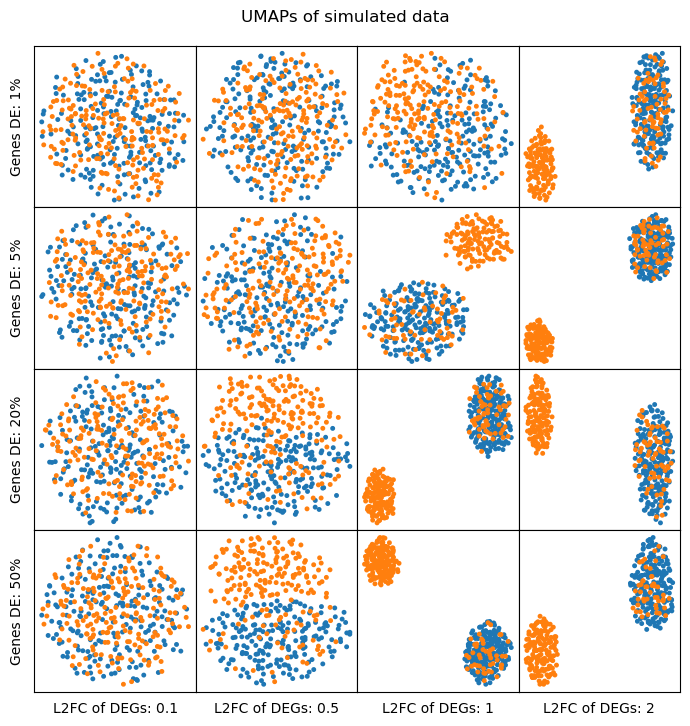

In [62]:
fig, axss = pl.subplots(4, 4, figsize=(7, 7), gridspec_kw={'wspace':0, 'hspace':0})
for axs, pDE in zip(axss, df.index):
    for ax, pLFC in zip(axs, df.columns):
        tdata = adatas[f'{pDE}_{pLFC}_data.csv']
        sc.pl.umap(tdata, color='group', legend_loc='None', ax=ax, show=False, s=50)
        # ax.set_title(f'Proportion DE genes: {pDE},\nL2FC of DEGs: {pLFC}')
        ax.set_title('')
        if ax==axs[0]:
            ax.set_ylabel(f'Genes DE: {int(float(pDE)*100)}%')
        else:
            ax.set_ylabel('')
        if all(axs==axss[-1]): 
            ax.set_xlabel(f'L2FC of DEGs: {pLFC}')
        else:
            ax.set_xlabel('')
pl.tight_layout()
pl.suptitle('UMAPs of simulated data', y=1.03)
pl.savefig('DEG_simulation_umaps.pdf', bbox_inches='tight')
pl.show()